**Сравнение методов решения многокритериальной задачи оптимизации**

In [ ]:
import numpy as np
import pandas as pd

from scipy.optimize import linprog

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#####Генерация тестовых данных

In [ ]:
np.random.seed(94)

In [ ]:
A = np.zeros((5, 6), dtype=int)
ri = np.random.randint(0, 5) # в какой строке будет 6
rj = np.random.randint(0, 6) # в каком столбце будет 6
for i in range(5):
  for j in range(6):
    if (i == ri) and (j == rj):
      A[i, j] = 6
    else:
      A[i, j] = np.random.randint(1, 6)
f3 = np.apply_along_axis(lambda x: np.sum(x), axis=0, arr=A)

b = np.zeros(6, dtype=int)
b[5] = np.random.randint(1000, 3500)

f1 = np.zeros(6, dtype=int)
f2 = np.zeros(6, dtype=int)
for i in range(6):
  f1[i] = np.random.randint(1, 5)
  f2[i] = np.random.randint(7, 13)
  if i != 5:
    b[i] = np.random.randint(200, 401)
A = np.vstack((A, f2))

In [ ]:
A

array([[ 1,  4,  3,  2,  1,  4],
       [ 1,  1,  1,  3,  2,  3],
       [ 5,  2,  1,  3,  1,  4],
       [ 1,  1,  6,  1,  4,  3],
       [ 4,  3,  3,  4,  1,  2],
       [ 7, 10,  9, 11,  7, 10]])

In [ ]:
b

array([ 297,  229,  236,  263,  343, 3234])

In [ ]:
f1

array([2, 4, 2, 3, 2, 3])

In [ ]:
f2

array([ 7, 10,  9, 11,  7, 10])

In [ ]:
f3

array([12, 11, 14, 13,  9, 16])

#####Индивидуальные экстремальные значения

In [ ]:
# Определим индивидуальные экстремальные значения критериев
bnd = np.array([(10, 100), (10, 100), (10, 100),
                (10, 100), (10, 100), (10, 100)])
f1_opt = linprog(c=np.negative(f1), A_ub=A, b_ub=b, bounds=bnd)
f2_opt = linprog(c=f2, A_ub=A, b_ub=b, bounds=bnd)
f3_opt = linprog(c=f3, A_ub=A, b_ub=b, bounds=bnd)

In [ ]:
# На полученных решениях вычислим значения критериев соответственно

f2_f1opt, f3_f1opt = 0, 0
f1_f2opt, f3_f2opt = 0, 0
f1_f3opt, f2_f3opt = 0, 0

for i in range(6):
  f2_f1opt += f2[i]*f1_opt.x[i]
  f3_f1opt += f3[i]*f1_opt.x[i]

  f1_f2opt += f1[i]*f2_opt.x[i]
  f3_f2opt += f3[i]*f2_opt.x[i]

  f1_f3opt += f1[i]*f3_opt.x[i]
  f2_f3opt += f2[i]*f3_opt.x[i]

print(f"f1*={-f1_opt.fun}, f2={f2_f1opt}, f3={f3_f1opt}")
print(f"f2*={f2_opt.fun}, f1={f1_f2opt}, f3={f3_f2opt}")
print(f"f3*={f3_opt.fun}, f1={f1_f3opt}, f2={f2_f3opt}")

f1*=312.0, f2=957.1428571428571, f3=1233.0
f2*=540.0, f1=160.0, f3=750.0
f3*=750.0, f1=160.0, f2=540.0


##Метод последовательных уступок

Поскольку наиболее приоритетной для фирмы является максимизация дохода со всех коммуникаций, критерий f1 - главный. Далее по значимости выбран (определили аналитики компании) критерий f2, так как затраты на проведение акций должны быть минимально возможными, а это означает, что наименьшим приоритетом обладает критерий f3, минимизирующий уровень предельной нагрузки каналов. Таким образом, порядок важности критериев: f1, f2, f3.

In [ ]:
def delta_method(percents):
  x = []
  y_f1 = []
  y_f2 = []
  y_f3 = []
  for p in percents:
    x.append(p)

    new_A = np.vstack((A, np.negative(f1)))

    ogr = -f1_opt.fun * (1 - p)
    new_b = np.hstack((b, np.negative(np.array(ogr))))
    y_f1.append(ogr)

    print(f"{'-'*15}\nf1(индив.) = {-f1_opt.fun}; при уступке {round(p*100)}% f1* = {ogr}, Δ = {-f1_opt.fun - ogr}")
    print()

    # Решаем задачу минимизации критерия f2
    min_f2 = linprog(c=f2, A_ub=new_A, b_ub=new_b, bounds=bnd)

    new_A = np.vstack((new_A, f2))

    ogr = min_f2.fun * (1 + p)
    new_b = np.hstack((new_b, np.array(ogr)))

    y_f2.append(ogr)

    print(f"min f2 = {min_f2.fun}; при уступке {round(p*100)}% f2* = {ogr}, Δ = {abs(min_f2.fun - ogr)}")

    # Решаем задачу минимизации критерия f3
    min_f3 = linprog(c=f3, A_ub=new_A, b_ub=new_b, bounds=bnd)

    y_f3.append(min_f3.fun)

    print(f"f3* = {min_f3.fun}")
    print()
    if p == 0.15:
      print(min_f3.x)
  return (x, y_f1, y_f2, y_f3)

In [ ]:
# Зададим величины уступки для критериев f1 и f2
percents = [0.05, 0.1, 0.15, 0.2]

x, y_f1, y_f2, y_f3 = delta_method(percents)

---------------
f1(индив.) = 312.0; при уступке 5% f1* = 296.4, Δ = 15.600000000000023

min f2 = 881.0; при уступке 5% f2* = 925.0500000000001, Δ = 44.05000000000007
f3* = 1125.1

---------------
f1(индив.) = 312.0; при уступке 10% f1* = 280.8, Δ = 31.19999999999999

min f2 = 842.0; при уступке 10% f2* = 926.2, Δ = 84.20000000000005
f3* = 1082.2

---------------
f1(индив.) = 312.0; при уступке 15% f1* = 265.2, Δ = 46.80000000000001

min f2 = 803.0; при уступке 15% f2* = 923.4499999999999, Δ = 120.44999999999993
f3* = 1039.3

[10.  36.3 10.  10.  10.  10. ]
---------------
f1(индив.) = 312.0; при уступке 20% f1* = 249.60000000000002, Δ = 62.39999999999998

min f2 = 764.0; при уступке 20% f2* = 916.8, Δ = 152.79999999999995
f3* = 996.4000000000001



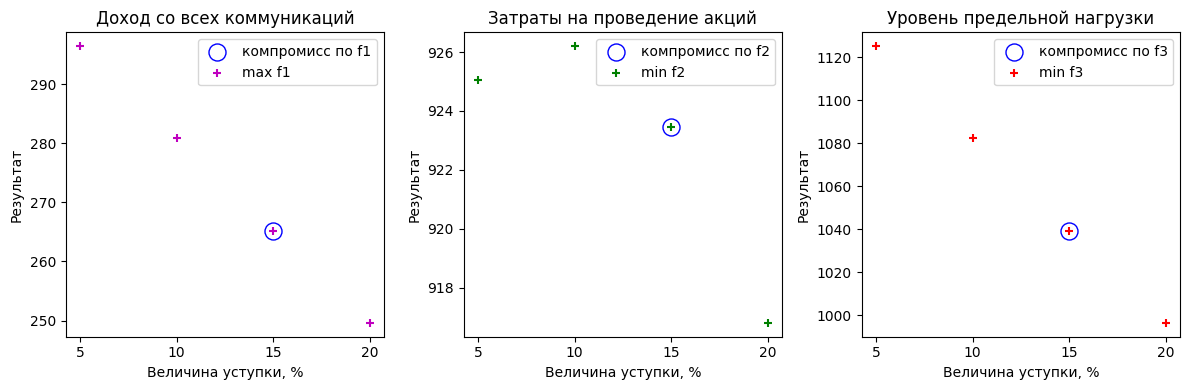

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.setp(ax, xticks=x, xticklabels=['5', '10', '15', '20'])

ax[0].set_title("Доход со всех коммуникаций")
ax[0].scatter(x[2], y_f1[2], c='white', label="компромисс по f1", marker="o", s=150, edgecolors="blue")
ax[0].scatter(x, y_f1, c='m', label="max f1", marker="+")
ax[1].set_title("Затраты на проведение акций")
ax[1].scatter(x[2], y_f2[2], c='white', label="компромисс по f2", marker="o", s=150, edgecolors="blue")
ax[1].scatter(x, y_f2, c='green', label="min f2", marker="+")
ax[2].scatter(x[2], y_f3[2], c='white', label="компромисс по f3", marker="o", s=150, edgecolors="blue")
ax[2].set_title("Уровень предельной нагрузки")
ax[2].scatter(x, y_f3, c='red', label="min f3", marker="+")
for i in range(3):
  ax[i].set_xlabel("Величина уступки, %")
  ax[i].set_ylabel("Результат")
  ax[i].legend()

fig.tight_layout()
plt.show()

Таким образом, наилучшие компромиссные результаты достигаются при величине уступки в 15%:

max *f1* = 265.2 (312 инд.)

min *f2* = 923.4 (540 инд.)

min *f3* = 1039.3 (750 инд.)

##Метод весовых коэффициентов

In [ ]:
# Зададим значения весовых коэффициентов для перебора
alpha = [[0.55, 0.3, 0.15],
         [0.6, 0.33, 0.07],
         [0.65, 0.25, 0.1],
         [0.7, 0.18, 0.12],
         [0.75, 0.2, 0.05]]

In [ ]:
vals = []
for a in alpha:
  res_f1 = []
  res_f2 = []
  res_f3 = []
  F = a[0]*f1/(-f1_opt.fun) - a[1]*f2/f2_opt.fun - a[2]*f3/f3_opt.fun
  result = linprog(c=np.negative(F), A_ub=A, b_ub=b, bounds=bnd)
  if a[0] == 0.65:
    print(result.x)
  for i in range(6):
    res_f1.append(f1[i]*result.x[i])
    res_f2.append(f2[i]*result.x[i])
    res_f3.append(f3[i]*result.x[i])
  res_f1.append(np.sum(res_f1))
  res_f2.append(np.sum(res_f2))
  res_f3.append(np.sum(res_f3))
  vals.append([(a[0], a[1], a[2]), (res_f1[6], res_f2[6], res_f3[6])])

[10.   46.75 10.   10.   10.   10.  ]


In [ ]:
vals

[[(0.55, 0.3, 0.15), (160.0, 540.0, 750.0)],
 [(0.6, 0.33, 0.07), (307.0, 907.5, 1154.25)],
 [(0.65, 0.25, 0.1), (307.0, 907.5, 1154.25)],
 [(0.7, 0.18, 0.12), (307.0, 907.5, 1154.25)],
 [(0.75, 0.2, 0.05), (312.0, 930.0, 1185.5)]]

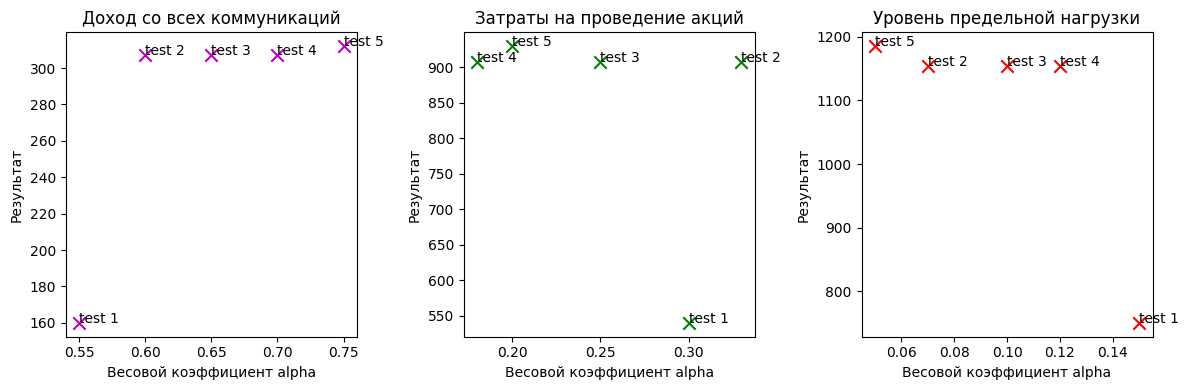

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

ax[0].set_title("Доход со всех коммуникаций")
ax[1].set_title("Затраты на проведение акций")
ax[2].set_title("Уровень предельной нагрузки")

for i in range(5):
  ax[0].scatter(vals[i][0][0], vals[i][1][0], c='m', marker="x", s=80)
  ax[0].annotate(f"test {i+1}", (vals[i][0][0], vals[i][1][0]))

  ax[1].scatter(vals[i][0][1], vals[i][1][1], c='green', marker="x", s=80)
  ax[1].annotate(f"test {i+1}", (vals[i][0][1], vals[i][1][1]))

  ax[2].scatter(vals[i][0][2], vals[i][1][2], c='red', marker="x", s=80)
  ax[2].annotate(f"test {i+1}", (vals[i][0][2], vals[i][1][2]))

for i in range(3):
  ax[i].set_xlabel("Весовой коэффициент alpha")
  ax[i].set_ylabel("Результат")

fig.tight_layout()
plt.show()

Таким образом, близкий к методу последовательных уступок результат можно получить, например, при следующих значениях весовых коэффициентов: (0.65, 0.25, 0.1). Тогда имеем:

max *f1* = 307 (265.2 уст.) (312 инд.)

min *f2* = 907.5 (923.4 уст.) (540 инд.)

min *f3* = 1154.25 (1039.3 уст.) (750 инд.)

##Метод компромиссной переменной

In [ ]:
# Введем компромиссную переменную и доп. ограничения
new_A = np.hstack((A, np.zeros((6, 1), dtype=int)))

new_A = np.vstack((new_A, np.hstack((np.negative(f1), np.negative(-f1_opt.fun)))))
new_b = np.hstack((b, np.negative(-f1_opt.fun)))

new_A = np.vstack((new_A, np.hstack((f2, -f2_opt.fun))))
new_b = np.hstack((new_b, f2_opt.fun))

new_A = np.vstack((new_A, np.hstack((f3, -f3_opt.fun))))
new_b = np.hstack((new_b, f3_opt.fun))

new_bnd = np.vstack((bnd, np.array([(0, float("inf"))])))

# Минимизируем вспомогательную целевую функцию
F = np.array([0, 0, 0, 0, 0, 0, 1])
F_min = linprog(c=F, A_ub=new_A, b_ub=new_b, bounds=new_bnd)

In [ ]:
F_min.fun

0.28787878787878785

In [ ]:
F_min.x

array([10.        , 25.54545455, 10.        , 10.        , 10.        ,
       10.        ,  0.28787879])

Значение z* = 0.2879 показывает, что относительные отклонения компромиссных значений критериев f1, f2 и f3 от их индивидуальных оптимальных величин не превышает 29%.

In [ ]:
f1_z, f2_z, f3_z = 0, 0, 0
for i in range(6):
  f1_z += f1[i]*F_min.x[i]
  f2_z += f2[i]*F_min.x[i]
  f3_z += f3[i]*F_min.x[i]
print(f"f1 = {f1_z}\nf2 = {f2_z}\nf3 = {f3_z}")

f1 = 222.1818181818182
f2 = 695.4545454545455
f3 = 921.0


Таким образом, при решении задачи с помощью метода компромиссной переменной получены следующие результаты:

max *f1* = 222.18 (307 вес.) (265.2 уст.) (312 инд.)

min *f2* = 695.45 (907.5 вес.) (923.4 уст.) (540 инд.)

min *f3* = 921 (1154.25 вес.) (1039.3 уст.) (750 инд.)

##Метод равных отклонений

In [ ]:
# Построим замещающую задачу, добавив новые переменные и оганичения
new_A = np.hstack((A, np.zeros((6, 6))))

In [ ]:
new_A

array([[ 1.,  4.,  3.,  2.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  3.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  2.,  1.,  3.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  6.,  1.,  4.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  3.,  4.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 7., 10.,  9., 11.,  7., 10.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [ ]:
eq_f1 = np.hstack((f1, np.negative(f1)))

eq_f2 = np.hstack((f2, np.negative(f2)))
eq_A = np.vstack((eq_f1, eq_f2))

eq_f3 = np.hstack((f3, np.negative(f3)))
eq_A = np.vstack((eq_A, eq_f3))
eq_A

array([[  2,   4,   2,   3,   2,   3,  -2,  -4,  -2,  -3,  -2,  -3],
       [  7,  10,   9,  11,   7,  10,  -7, -10,  -9, -11,  -7, -10],
       [ 12,  11,  14,  13,   9,  16, -12, -11, -14, -13,  -9, -16]])

In [ ]:
f1_ratio = f1/-f1_opt.fun
f2_ratio = f2/f2_opt.fun
f3_ratio = f3/f3_opt.fun

In [ ]:
eq_A = np.vstack((eq_A, np.hstack((f1_ratio, f2_ratio))))
eq_A = np.vstack((eq_A, np.hstack((f1_ratio, f3_ratio))))

In [ ]:
new_bnd = np.vstack((bnd, bnd))

In [ ]:
eq_b = np.array([0, 0, 0, 2, 2])

In [ ]:
new_A.shape

(6, 12)

In [ ]:
new_f1 = np.hstack((f1, np.zeros(6)))

In [ ]:
# Решим задачу максимизации по главному критерию f1
f1_max = linprog(c=np.negative(new_f1), A_ub=new_A, b_ub=b,
                 A_eq=eq_A, b_eq=eq_b, bounds=new_bnd)

In [ ]:
f1_max.x[:6]

array([21.05145414, 18.71364653, 10.        , 10.        , 10.        ,
       10.        ])

In [ ]:
res_f2, res_f3 = 0, 0
for i in range(6):
  res_f2 += f2[i]*f1_max.x[i]
  res_f3 += f3[i]*f1_max.x[i]
print(f"f1 = {-f1_max.fun}\nf2 = {res_f2}\nf3 = {res_f3}")

f1 = 216.95749440715883
f2 = 704.4966442953021
f3 = 978.4675615212531


Таким образом, при решении задачи с помощью метода равных отклонений получены следующие результаты:

max *f1* = 216.96 (222.18 компр.) (307 вес.) (265.2 уст.) (312 инд.)

min *f2* = 704.5 (695.45 компр.) (907.5 вес.) (923.4 уст.) (540 инд.)

min *f3* = 978.47 (921 компр.) (1154.25 вес.) (1039.3 уст.) (750 инд.)

#####Вывод


При использовании различных методов при решении многокритериальных задач возможен разброс результатов. Наиболее близкие к индивидуальным экстремальным значениям критериев результаты решения задачи линейной оптимизации на сгенерированных данных были получены с помощью метода компромиссной переменной.